<a href="https://colab.research.google.com/github/nikenhpsr/projects/blob/main/GPV_Reserve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a group project implemented to fulfill the thematic internship course. The group consists of several members, namely:
1. [David Eurico](https://www.linkedin.com/in/davideurico)
2. [Sandra Kezia](https://www.linkedin.com/in/sandra-kezia-3514b31ab/)
3. [Niken Hapsari Agustiningrum](https://www.linkedin.com/in/nikenhapsari/) (me)
4. [Azka Fadhilah Nurfatmasari](https://www.linkedin.com/in/azkafadhilahn/)
5. [Alma Justica](https://www.linkedin.com/in/alma-justica/)
6. [Safira Azzahra](https://www.linkedin.com/in/safira-azzahra-35596b173/)
7. Hanifudin Nurhidayat

This project aim to calculate GPV Reserve for Endowment Policy based on Monthly and Annualy Valuation. The output of this code are gross premium, gpv reserve for each year, and some of the plots as stated below.


In [5]:
#Package for generating numbers for looping
import numpy as np

#Package for handling DataFrame and read imported files
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.options.display.float_format = '{:,}'.format

#Package for generating plot of the result
import matplotlib.pyplot as plt

#Package for importing files from Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
#Annual GPV Reserve Formula
def GPV_RESERVE_ANNUALLY():
    #Assign Mortality, Disability, and Alive Probability Table
    tmi = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Materi Magang/TMI.xlsx")
    tmim = tmi["Laki-Laki"]
    tmif = tmi["Perempuan"]

    tci = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Materi Magang/TCI.xlsx")
    tcim = tci["Laki-Laki"]
    tcif = tci["Perempuan"]

    th = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Materi Magang/TH.xlsx")
    thm = th["Laki-Laki"]
    thf = th["Perempuan"]
    
    #Input Data
    age = int(input("Insured's Age: "))
    gender = str(input("Insured's Gender (m or f): "))
    protection_term = int(input("Insured's Protection Term: "))
    payment_term = int(input("Insured's Payment Term: "))
    loyalty_term = int(input("Insured's Loyalty Bonus: "))
    interest = float(input("Interest: "))
    benefit = int(input("Insured's Benefit: "))
    if gender=="m":
        tht = thm
        tmd = tmim
        tc = tcim
    elif gender=="f":
        tht = thf
        tmd = tmif
        tc = tcif
    
    #Define Function
    "Probability to keep alive"
    def tpx(age,term):
        if term==0:
            return 1
        elif term>0:
            z=1
            for w in np.arange(term):
                z = z*tht[(age+w)]
            return z

    "Discount Factor"    
    def v(interest,term):
        v=(1+interest)**(-term)
        return v

    "Annuity Due"
    def adue(age,payment_term,interest):
        a=0
        for w in np.arange(payment_term):
            a += v(interest,w)*tpx(age,w)
        return a
    
    "Net Single Premium of Death Benefit"
    def NSPD(age,protection_term,interest):
        NSPD = 0
        for w in np.arange(protection_term):
            NSPD += v(interest,w+1)*tpx(age,w)*tmd[age+w]
        t = (NSPD)*(interest/np.log(1+interest))
        return t

    "Net Single Premium of Disability Benefit"
    def NSPC(age,protection_term,interest):
        NSPC = 0
        for w in np.arange(protection_term):
            NSPC += v(interest,w+1)*tpx(age,w)*tc[age+w]
        t = (NSPC)*(interest/np.log(1+interest))
        return t
    
    "Gross Premium Function"
    def GP(benefit,age,protection_term,payment_term,interest):
        Claim_Benefit = benefit*(NSPD(age,protection_term,interest)+NSPC(age,protection_term,interest)+0.2*v(interest,protection_term)*tpx(age,protection_term))
        Pembilang = Claim_Benefit+360000*adue(age,payment_term,interest)
        Penyebut = adue(age,payment_term,interest)-0.5*(1+v(interest,loyalty_term)*tpx(age,loyalty_term))
        ppp = Pembilang/Penyebut
        return ppp
    
    #GPV Reserve
    list_gpv=[]
    list_premium=[]
    list_death=[]
    list_disable=[]
    list_endow=[]
    list_admin=[]
    list_policy=[]
    list_loyalty=[]
    
    gross_premium = GP(benefit,age,protection_term,payment_term,interest)
    for i in np.arange(0,protection_term+1):
        if i==0:
            policy_fee = 0.5*gross_premium
        else:
            policy_fee = 0
        
        if i<=payment_term-1:
            admin_fees = 360000*adue(age+i,payment_term-i,interest)
            income = gross_premium*adue(age+i,payment_term-i,interest)
        else:
            admin_fees = 0
            income = 0
            
        if i<=loyalty_term:
            loyalty_bonus = 0.5*gross_premium*tpx(age+i,loyalty_term-i)*v(interest,loyalty_term-i)
        else:
            loyalty_bonus = 0
            
        if i<=protection_term-1:
            disable_benefit = benefit*NSPC(age+i,protection_term-i,interest)
            death_benefit = benefit*NSPD(age+i,protection_term-i,interest)
        else:
            disable_benefit = 0
            death_benefit = 0
            
        endowment = 0.2*benefit*v(interest, protection_term-i)*tpx(age+i,protection_term-i)
        "Append elements to list"
        list_premium.append(round(income,2))
        list_death.append(round(death_benefit,2))
        list_disable.append(round(disable_benefit,2))
        list_endow.append(round(endowment,2))
        list_admin.append(round(admin_fees,2))
        list_policy.append(round(policy_fee,2))
        list_loyalty.append(round(loyalty_bonus,2))
        list_gpv.append(round(admin_fees+loyalty_bonus+endowment+death_benefit+disable_benefit+policy_fee-income,2))

    #Plot all Components :D
    figure, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8, figsize=(15, 45))
    ax1.plot(list_premium)
    ax1.set_title("Plot Gross Premium")
    ax1.ticklabel_format(style='plain')

    ax2.plot(list_death)
    ax2.set_title("Plot Death Benefit")
    ax2.ticklabel_format(style='plain')

    ax3.plot(list_disable)
    ax3.set_title("Plot Disability Benefit")
    ax3.ticklabel_format(style='plain')

    ax4.plot(list_endow)
    ax4.set_title("Plot Endowment Benefit")
    ax4.ticklabel_format(style='plain')

    ax5.plot(list_admin)
    ax5.set_title("Plot Administration Fees")
    ax5.ticklabel_format(style='plain')  

    ax6.plot(list_policy)
    ax6.set_title("Plot Policy Fee")
    ax6.ticklabel_format(style='plain')

    ax7.plot(list_loyalty)
    ax7.set_title("Plot Loyalty Bonus")
    ax7.ticklabel_format(style='plain')

    ax8.plot(list_gpv)
    ax8.set_title("Plot GPV Reserves")
    ax8.ticklabel_format(style='plain')

    #Output     
    print("Gross Premium: ", gross_premium)
    result = pd.DataFrame({'Income': list_premium, 'Death': list_death, 'Disability': list_disable, 'Endowment': list_endow, 'Admin Fees': list_admin, 'Policy Fee':list_policy, 'Loyalty Bonus': list_loyalty, 'GPV': list_gpv})
    return result

Insured's Age: 20
Insured's Gender (m or f): m
Insured's Protection Term: 20
Insured's Payment Term: 7
Insured's Loyalty Bonus: 8
Interest: 0.07
Insured's Benefit: 1000000000
Gross Premium:  12261831.75084002


,Income,Death,Disability,Endowment,Admin Fees,Policy Fee,Loyalty Bonus,GPV
0,"70,608,658.58","7,660,896.2","383,044.81","50,807,969.15","2,073,027.72","6,130,915.88","3,552,804.83",-0.0
1,"62,463,241.3","7,694,160.86","384,708.04","54,392,511.28","1,833,883.17",0.0,"3,803,458.0","5,645,480.06"
2,"53,743,158.42","7,729,772.37","386,488.62","58,229,945.68","1,577,866.78",0.0,"4,071,794.95","18,252,709.99"
3,"44,407,866.85","7,767,896.3","388,394.82","62,338,114.09","1,303,788.24",0.0,"4,359,063.29","31,749,389.88"
4,"34,413,963.13","7,808,709.91","390,435.5","66,736,117.01","1,010,373.24",0.0,"4,666,598.62","46,198,271.15"
5,"23,715,230.78","7,842,133.94","392,106.7","71,445,153.01","696,264.9",0.0,"4,995,883.3","61,656,311.09"
6,"12,261,831.75","7,857,378.56","392,868.93","76,488,075.18","360,000.0",0.0,"5,348,515.35","78,185,006.27"
7,0.0,"7,842,891.26","392,144.56","81,889,530.41",0.0,0.0,"5,726,218.23","95,850,784.47"
8,0.0,"7,776,029.2","388,801.46","87,677,032.49",0.0,0.0,"6,130,915.88","101,972,779.02"
9,0.0,"7,653,080.83","382,654.04","93,878,494.85",0.0,0.0,0.0,"101,914,229.72"


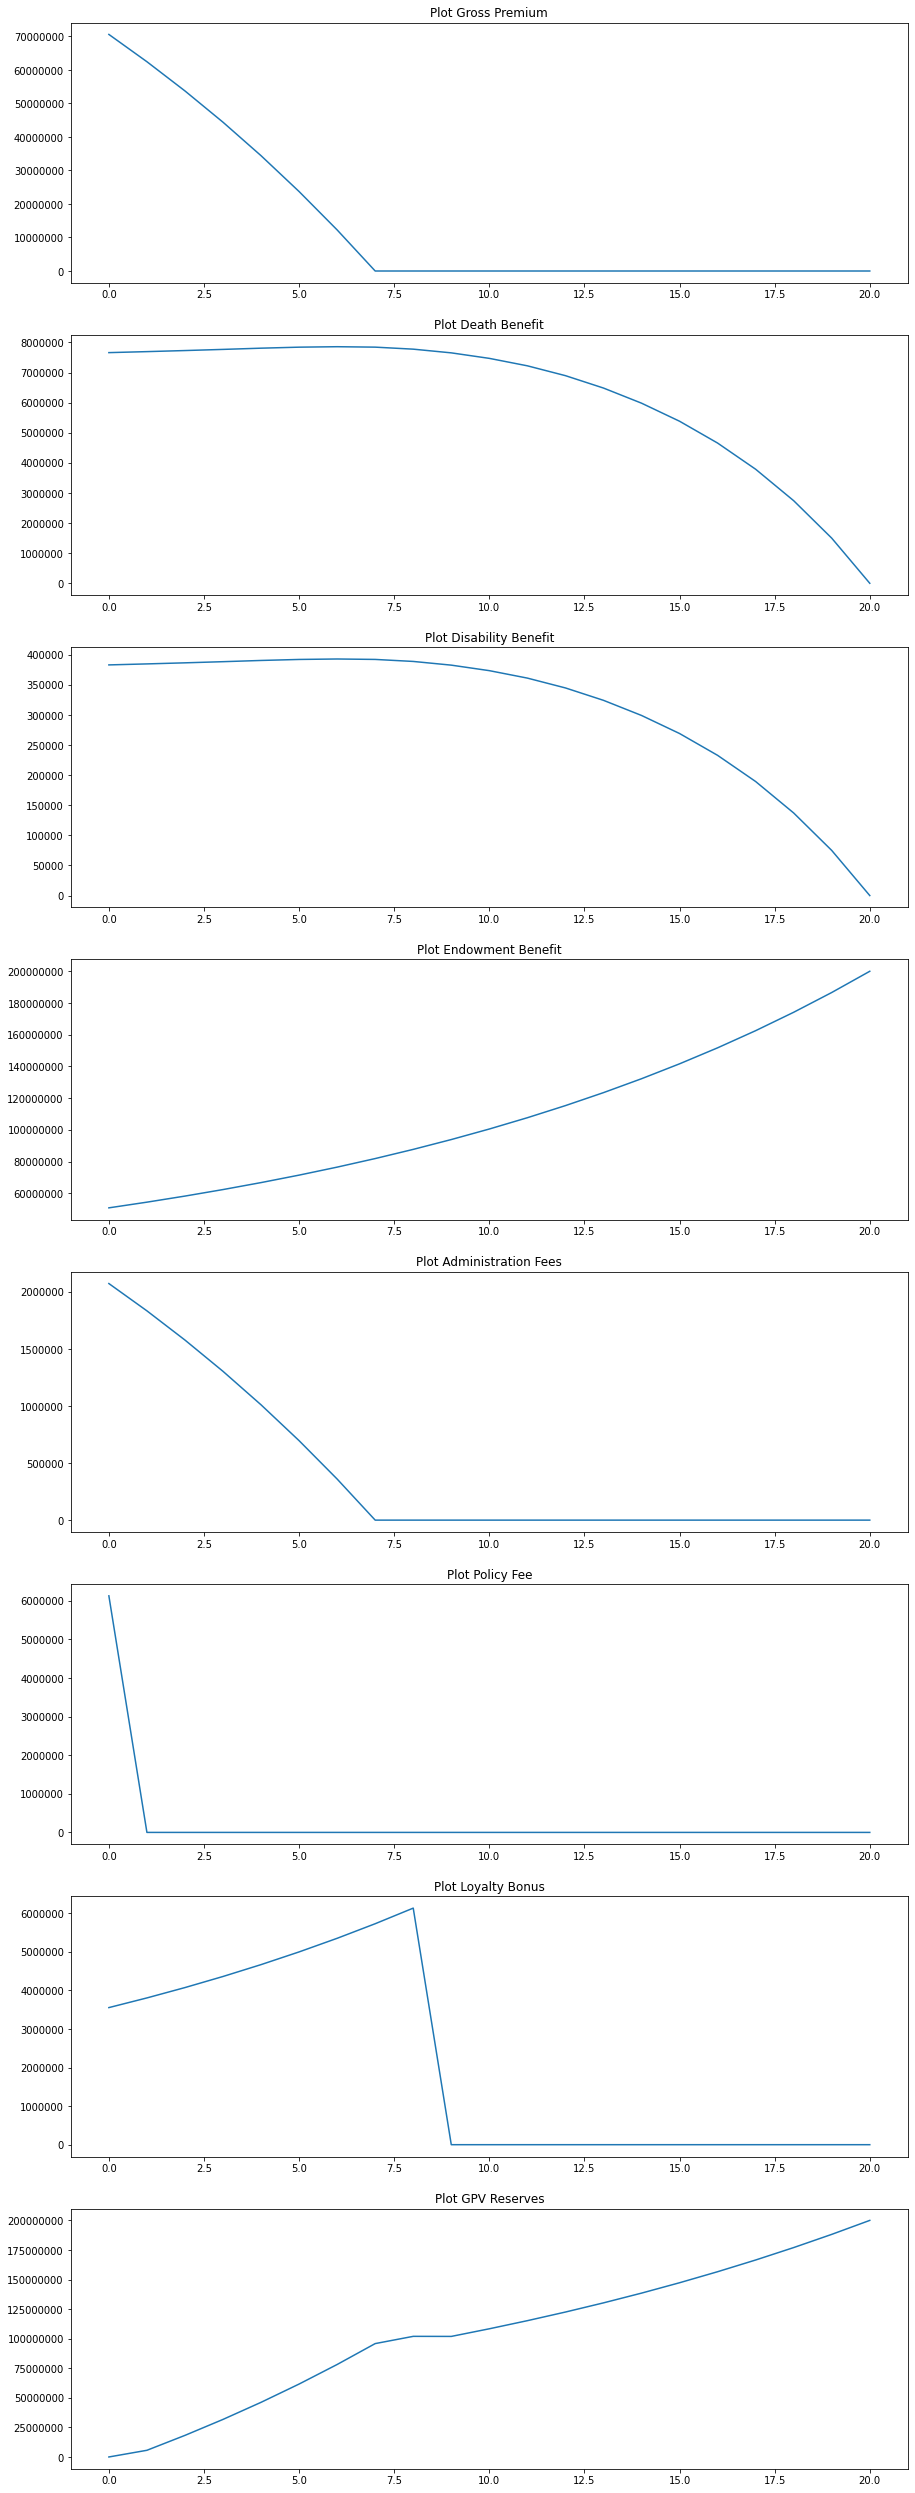

In [11]:
GPV_RESERVE_ANNUALLY()

In [12]:
def GPV_RESERVE_MONTHLY():
    #Assign Mortality, Disability, and Alive Probability Table
    tmi = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Materi Magang/TMI Monthly.xlsx")
    tmim = tmi["Laki-Laki"]
    tmif = tmi["Perempuan"]

    tci = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Materi Magang/TCI Monthly.xlsx")
    tcim = tci["Laki-Laki"]
    tcif = tci["Perempuan"]

    th = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Materi Magang/TH Monthly.xlsx")
    thm = th["Laki-Laki"]
    thf = th["Perempuan"]
    
    #Input Data
    age = int(input("Insured's Age: "))
    gender = str(input("Insured's Gender (m or f): "))
    protection_term = int(input("Insured's Protection Term: "))
    payment_term = int(input("Insured's Payment Term: "))
    loyalty_term = int(input("Insured's Loyalty Bonus: "))
    interest = float(input("Interest: "))
    benefit = int(input("Insured's Benefit: "))
    if gender=="m":
        tht = thm
        tmd = tmim
        tc = tcim
    elif gender=="f":
        tht = thf
        tmd = tmif
        tc = tcif
        
    #Monthly Modification
    interest = ((1+interest)**(1/12)-1)
    age = age*12
    protection_term = protection_term*12
    payment_term = payment_term*12
    loyalty_term = loyalty_term*12
    
    #Define Function
    "Probability to keep alive"
    def tpx(age,term):
        if term==0:
            return 1
        elif term>0:
            z=1
            for w in np.arange(term):
                z = z*tht[(age+w)]
            return z

    "Discount Factor"    
    def v(interest,term):
        v=(1+interest)**(-term)
        return v

    "Annuity Due"
    def adue(age,payment_term,interest):
        a=0
        for w in np.arange(payment_term):
            a += v(interest,w)*tpx(age,w)
        return a
    
    "Net Single Premium of Death Benefit"
    def NSPD(age,protection_term,interest):
        NSPD = 0
        for w in np.arange(protection_term):
            NSPD += v(interest,w+1)*tpx(age,w)*tmd[age+w]
        t = (NSPD)*(interest/np.log(1+interest))
        return t

    "Net Single Premium of Disability Benefit"
    def NSPC(age,protection_term,interest):
        NSPC = 0
        for w in np.arange(protection_term):
            NSPC += v(interest,w+1)*tpx(age,w)*tc[age+w]
        t = (NSPC)*(interest/np.log(1+interest))
        return t
    
    "Gross Premium Function"
    def GP(benefit,age,protection_term,payment_term,interest):
        Claim_Benefit = benefit*(NSPD(age,protection_term,interest)+NSPC(age,protection_term,interest)+0.2*v(interest,protection_term)*tpx(age,protection_term)+0.01*v(interest,loyalty_term)*tpx(age,loyalty_term))
        Pembilang = Claim_Benefit+30000*adue(age,payment_term,interest)
        Penyebut = adue(age,payment_term,interest)-0.5*adue(age,12,interest)
        ppp = Pembilang/Penyebut
        return ppp
    
    #GPV Reserve Calculation
    list_gpv=[]
    list_premium=[]
    list_death=[]
    list_disable=[]
    list_endow=[]
    list_admin=[]
    list_policy=[]
    list_loyalty=[]
    
    gross_premium = GP(benefit,age,protection_term,payment_term,interest)
    for i in np.arange(0,protection_term+1):
        if i<=11:
            policy_fee = 0.5*gross_premium*adue(age+i,12-i,interest)
        else:
            policy_fee = 0
        
        if i<=payment_term-1:
            admin_fees = 30000*adue(age+i,payment_term-i,interest)
            income = gross_premium*adue(age+i,payment_term-i,interest)
        else:
            admin_fees = 0
            income = 0
            
        if i<=loyalty_term:
            loyalty_bonus = 0.01*benefit*tpx(age+i,loyalty_term-i)*v(interest,loyalty_term-i)
        else:
            loyalty_bonus = 0
            
        if i<=protection_term-1:
            disable_benefit = benefit*NSPC(age+i,protection_term-i,interest)
            death_benefit = benefit*NSPD(age+i,protection_term-i,interest)
        else:
            disable_benefit = 0
            death_benefit = 0
            
        endowment = 0.2*benefit*v(interest, protection_term-i)*tpx(age+i,protection_term-i)
        "Append elements to list"
        list_premium.append(round(income,2))
        list_death.append(round(death_benefit,2))
        list_disable.append(round(disable_benefit,2))
        list_endow.append(round(endowment,2))
        list_admin.append(round(admin_fees,2))
        list_policy.append(round(policy_fee,2))
        list_loyalty.append(round(loyalty_bonus,2))
        list_gpv.append(round(admin_fees+loyalty_bonus+endowment+death_benefit+disable_benefit+policy_fee-income,2))

    #Plot all Components :D
    figure, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8, figsize=(15, 45))
    ax1.plot(list_premium)
    ax1.set_title("Plot Gross Premium")
    ax1.ticklabel_format(style='plain')

    ax2.plot(list_death)
    ax2.set_title("Plot Death Benefit")
    ax2.ticklabel_format(style='plain')

    ax3.plot(list_disable)
    ax3.set_title("Plot Disability Benefit")
    ax3.ticklabel_format(style='plain')

    ax4.plot(list_endow)
    ax4.set_title("Plot Endowment Benefit")
    ax4.ticklabel_format(style='plain')

    ax5.plot(list_admin)
    ax5.set_title("Plot Administration Fees")
    ax5.ticklabel_format(style='plain')  

    ax6.plot(list_policy)
    ax6.set_title("Plot Policy Fee")
    ax6.ticklabel_format(style='plain')

    ax7.plot(list_loyalty)
    ax7.set_title("Plot Loyalty Bonus")
    ax7.ticklabel_format(style='plain')

    ax8.plot(list_gpv)
    ax8.set_title("Plot GPV Reserves")
    ax8.ticklabel_format(style='plain')

    #Output     
    print("Gross Premium: ", gross_premium)
    result = pd.DataFrame({'Income': list_premium, 'Death': list_death, 'Disability': list_disable, 'Endowment': list_endow, 'Admin Fees': list_admin, 'Policy Fee':list_policy, 'Loyalty Bonus': list_loyalty, 'GPV': list_gpv})
    return result

Insured's Age: 20
Insured's Gender (m or f): m
Insured's Protection Term: 20
Insured's Payment Term: 7
Insured's Loyalty Bonus: 8
Interest: 0.07
Insured's Benefit: 1000000000
Gross Premium:  1089666.878053045


,Income,Death,Disability,Endowment,Admin Fees,Policy Fee,Loyalty Bonus,GPV
0,"72,994,251.34","7,660,755.46","382,904.07","50,807,969.15","2,009,630.27","6,338,091.75","5,794,900.64",0.0
1,"72,314,243.9","7,663,450.39","383,038.06","51,097,435.59","1,990,908.75","5,826,264.04","5,827,915.72","474,768.64"
2,"71,630,362.41","7,666,159.01","383,172.8","51,388,551.29","1,972,080.56","5,311,520.32","5,861,118.91","952,240.49"
3,"70,942,584.77","7,668,881.41","383,308.31","51,681,325.63","1,953,145.12","4,793,843.97","5,894,511.27","1,432,430.95"
4,"70,250,888.8","7,671,617.66","383,444.59","51,975,768.08","1,934,101.79","4,273,218.29","5,928,093.89","1,915,355.51"
5,"69,555,252.17","7,674,367.84","383,581.64","52,271,888.13","1,914,949.98","3,749,626.47","5,961,867.85","2,401,029.75"
6,"68,855,652.42","7,677,132.03","383,719.47","52,569,695.35","1,895,689.05","3,223,051.61","5,995,834.24","2,889,469.33"
7,"68,152,066.97","7,679,910.3","383,858.07","52,869,199.34","1,876,318.4","2,693,476.72","6,029,994.15","3,380,690.01"
8,"67,444,473.12","7,682,702.74","383,997.47","53,170,409.78","1,856,837.38","2,160,884.7","6,064,348.7","3,874,707.65"
9,"66,732,848.02","7,685,509.43","384,137.66","53,473,336.39","1,837,245.38","1,625,258.35","6,098,898.98","4,371,538.17"


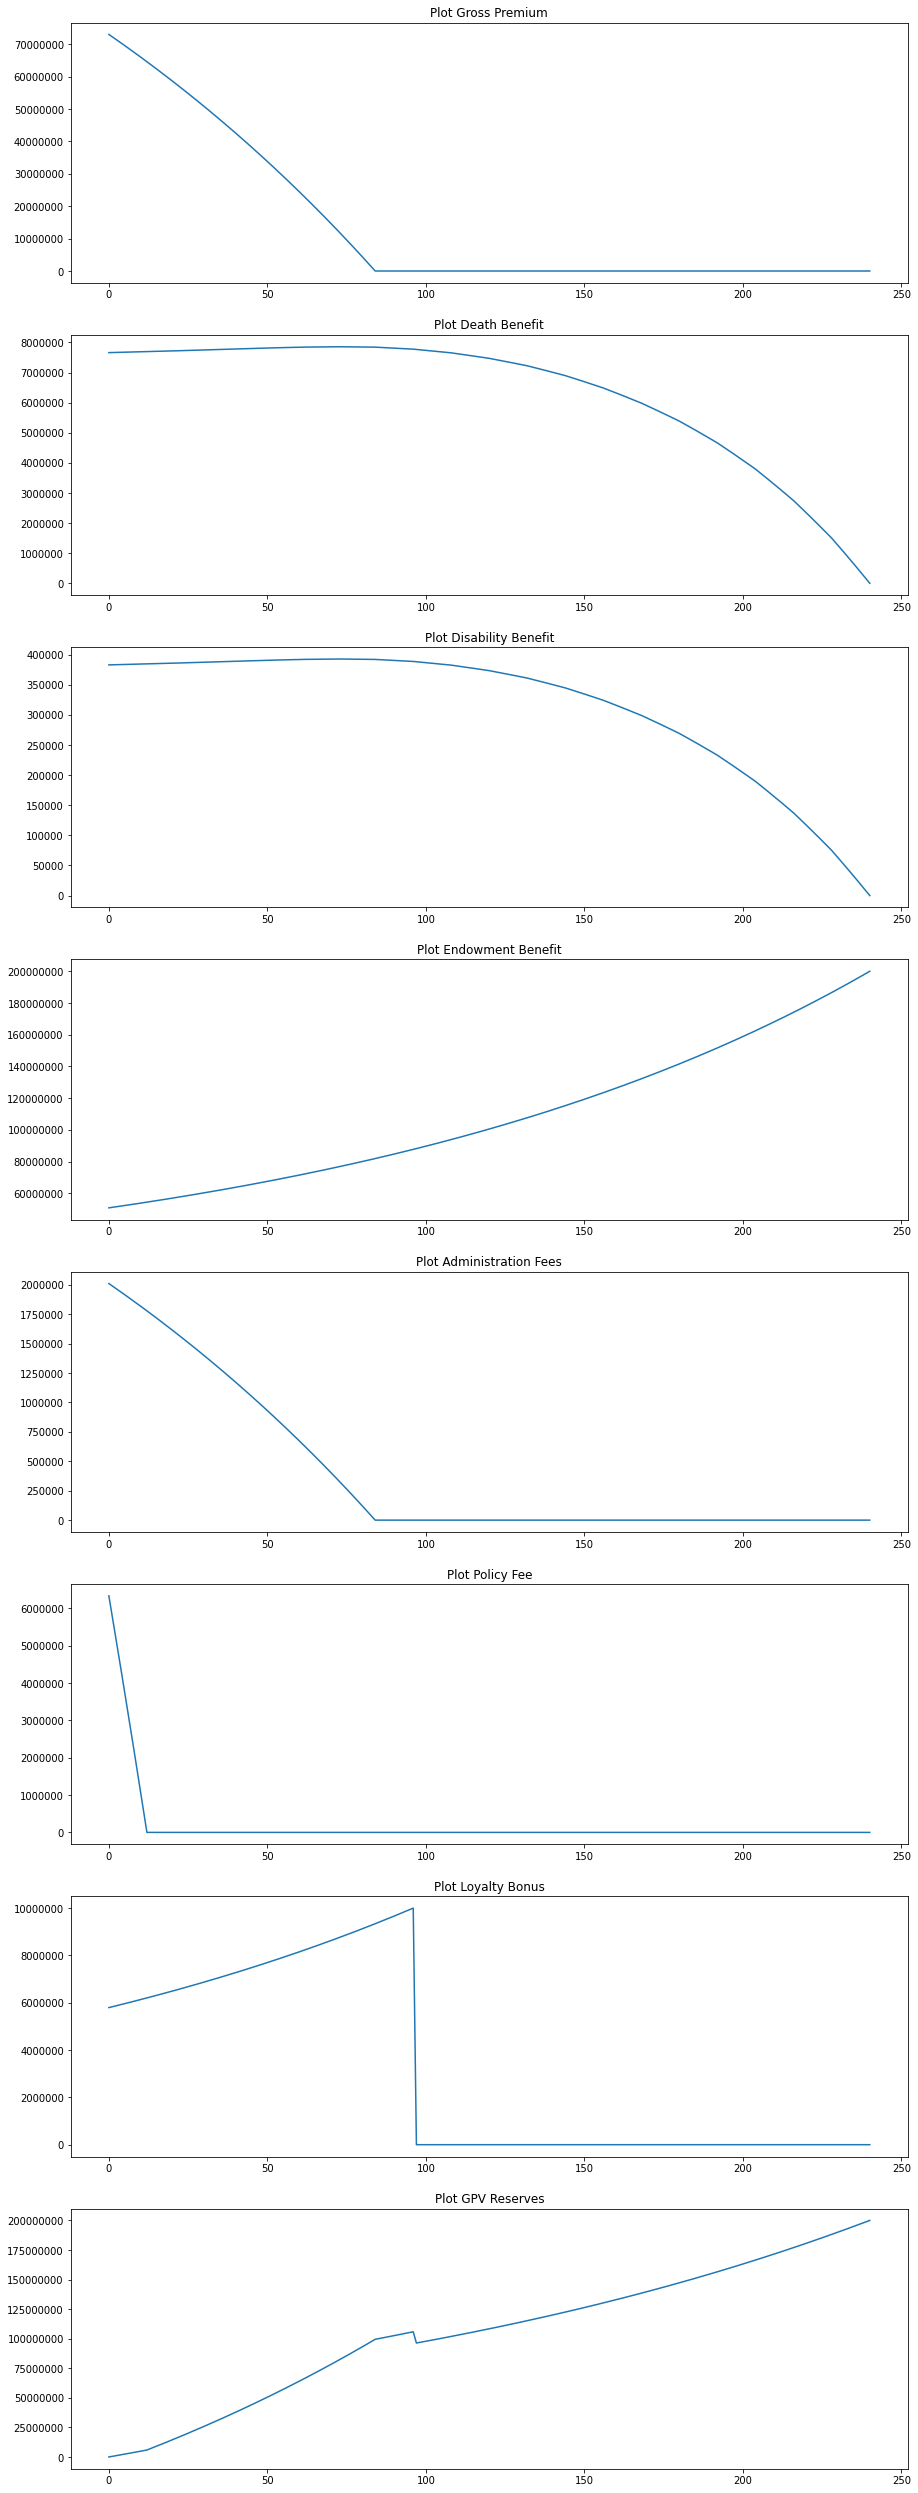

In [13]:
GPV_RESERVE_MONTHLY()

The example above is an illustration for insurance product that has:
* Insured age = 20
* Insured gender's = male
* Insured term of protection = 20 years
* Term of premium payment = 7 years
* Insured's loyalty bonus paid at year = 8
* Interest rate = 7%
* Benefit if one of the decrements happen = Rp1.000.000.000
* Endowment benefit = 20% decrement benefit